# Finalne modelowanie

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering, DBSCAN

In [2]:
data = pd.read_csv("data.csv")
X = data.drop(["subject", "Activity", "ActivityName"], axis=1)
y = data["Activity"]
# na wszelki wypadek dzielimy na zbiory treningowy i testowy,
# bo skoro jesteśmy w posiadaniu prawdziwych labeli, moglibyśmy chcieć jakoś
# sprawdzać trafność naszego modelu na niewidzianych przez niego danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,fBodyBodyGyroJerkMag_meanFreq,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,angletBodyAccMean_gravity,angletBodyAccJerkMean_gravityMean,angletBodyGyroMean_gravityMean,angletBodyGyroJerkMean_gravityMean,angleX_gravityMean,angleY_gravityMean,angleZ_gravityMean
5538,0.267568,-0.015712,-0.065980,-0.995271,-0.977984,-0.963060,-0.996078,-0.980578,-0.961130,-0.942153,...,0.420093,-0.616825,-0.794250,-0.004331,0.212652,-0.370062,-0.352681,-0.837084,0.099222,-0.101149
2755,0.277109,-0.013876,-0.112776,-0.997565,-0.987851,-0.992859,-0.997805,-0.987097,-0.994136,-0.942406,...,0.545749,-0.785950,-0.956767,-0.041486,0.331615,0.036768,0.112289,-0.872126,0.009535,0.043758
5813,0.223730,-0.048263,-0.105781,-0.461582,-0.094674,-0.287821,-0.511609,-0.119351,-0.311649,-0.078237,...,0.221168,-0.175540,-0.545833,0.307722,0.490644,-0.842834,-0.607873,-0.854541,0.180849,-0.041994
7506,0.285830,-0.004668,-0.152746,-0.433399,0.009730,0.120867,-0.491119,0.047058,0.087327,-0.151067,...,-0.000990,-0.107975,-0.507438,-0.310129,0.097989,0.527328,-0.689166,-0.306913,0.303946,0.452417
1334,0.270514,-0.019739,-0.129706,-0.988424,-0.980260,-0.968742,-0.989403,-0.978525,-0.967611,-0.933788,...,0.342991,-0.547240,-0.800976,0.001274,-0.359362,0.041658,-0.338905,-0.791197,0.139212,0.162886


In [3]:
def drop_correlated(X, threshold=0.97):
    corr_df = X.corr().abs()
    columns_to_leave = np.ones((corr_df.shape[0], 1), dtype=bool)
    for i in range(corr_df.shape[0]):
        if columns_to_leave[i]:
            for j in range(i+1, corr_df.shape[0]):
                if corr_df.iloc[i, j] >= threshold:
                    columns_to_leave[j] = False
    columns_to_leave =  columns_to_leave.reshape(1, corr_df.shape[0])[0]
    return X.loc[:, columns_to_leave]

In [4]:
X_train = drop_correlated(X_train)
X_train.head()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,...,fBodyBodyGyroJerkMag_min,fBodyBodyGyroJerkMag_iqr,fBodyBodyGyroJerkMag_maxInds,fBodyBodyGyroJerkMag_meanFreq,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,angletBodyAccMean_gravity,angletBodyAccJerkMean_gravityMean,angletBodyGyroMean_gravityMean,angletBodyGyroJerkMean_gravityMean
5538,0.267568,-0.015712,-0.065980,-0.995271,-0.977984,-0.963060,-0.550491,-0.789656,0.843383,0.691476,...,-0.995824,-0.996387,-1.000000,0.420093,-0.616825,-0.794250,-0.004331,0.212652,-0.370062,-0.352681
2755,0.277109,-0.013876,-0.112776,-0.997565,-0.987851,-0.992859,-0.564823,-0.822405,0.846542,0.691177,...,-0.999933,-0.997907,-0.523810,0.545749,-0.785950,-0.956767,-0.041486,0.331615,0.036768,0.112289
5813,0.223730,-0.048263,-0.105781,-0.461582,-0.094674,-0.287821,-0.129826,-0.334681,0.386962,0.081401,...,-0.909415,-0.583603,-0.904762,0.221168,-0.175540,-0.545833,0.307722,0.490644,-0.842834,-0.607873
7506,0.285830,-0.004668,-0.152746,-0.433399,0.009730,0.120867,-0.146341,-0.294388,0.424646,0.031001,...,-0.495843,-0.588718,-0.904762,-0.000990,-0.107975,-0.507438,-0.310129,0.097989,0.527328,-0.689166
1334,0.270514,-0.019739,-0.129706,-0.988424,-0.980260,-0.968742,-0.567375,-0.810410,0.836722,0.682680,...,-0.996252,-0.993925,-1.000000,0.342991,-0.547240,-0.800976,0.001274,-0.359362,0.041658,-0.338905


In [5]:
X_test = X_test[X_train.columns.to_list()]

## Modelowanie

In [6]:
def reshape(components):
    res = np.zeros((2, components.shape[0]))
    for i in range(len(components)):
        res[0][i] = components[i][0]
        res[1][i] = components[i][1]
    return res

def choose_best_tsne(X, perplexity=50, iterations=10):
    np.random.seed(42)
    random_states = np.random.choice(100, iterations, replace=False)
    best_model = None
    best_score = np.inf
    random_state = None
    
    X_transformed = PCA(n_components = 60, random_state=42).fit_transform(X)
    
    for i in range(iterations):
        tsne = TSNE(n_components = 2, 
                    perplexity = perplexity,
                    random_state = random_states[i])
        tsne.fit(X_transformed)
        if tsne.kl_divergence_ < best_score:
            best_score = tsne.kl_divergence_
            best_model = tsne
            random_state = random_states[i]
    
    return best_model

def plot_components(components, labels=None, title=True, legend_labels=None):
    X_transformed = reshape(components)
    plt.rcParams["figure.figsize"] = [20,15]
    fig, ax = plt.subplots()
    if labels is not None and legend_labels is None:
        ax.scatter(X_transformed[0], X_transformed[1], c=labels, cmap="coolwarm")
    if labels is None and legend_labels is None:
        ax.scatter(X_transformed[0], X_transformed[1])
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    if title:
        ax.set_title(model)
    if legend_labels is not None:
        for g in np.unique(labels):
            i = np.where(labels == g)
            ax.scatter(X_transformed[0][i], X_transformed[1][i], label=legend_labels[g-1])
        ax.legend()

In [7]:
#best_tsne = choose_best_tsne(X_train)

In [8]:
# można teraz nie liczyć na nowo, a ustawić od razu random_state = 22, perplexity = 50
best_tsne = TSNE(n_components=2, perplexity=50, random_state=22)
best_tsne.fit(PCA(n_components=60).fit_transform(X_train))

TSNE(perplexity=50, random_state=22)

In [9]:
nn = NearestNeighbors(n_neighbors=2, metric="euclidean")
pca = PCA(n_components = 60, random_state = 42)
X_train_pca = pca.fit_transform(X_train)
nn.fit(X_train_pca)
neighbors = nn.kneighbors(X_train_pca)[0]

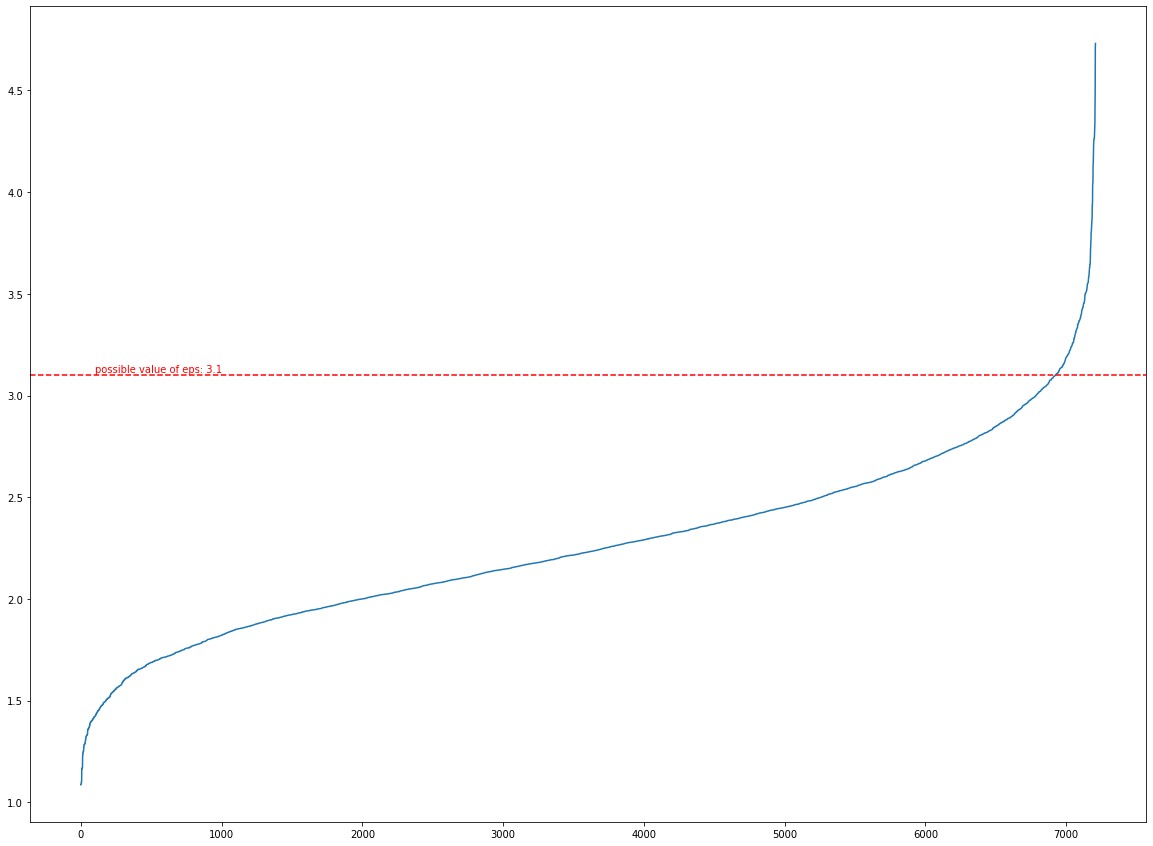

In [10]:
agg_neighbors = np.zeros(X_train.shape[0])

for i in range(X_train.shape[0]):
    agg_neighbors[i] = np.max(neighbors[i])

agg_neighbors = np.sort(agg_neighbors)

plt.rcParams["figure.figsize"] = [20,15]
plt.plot(np.arange(X_train.shape[0]), agg_neighbors)
plt.axhline(y=3.1, color="r", linestyle="dashed")
plt.text(1000,3.13, 
         "possible value of eps: 3.1", 
         color="red", 
        ha="right", va="center")
plt.show()
# podobno punkt, z którego się zaczyna nagły wzrost, oznacza dobry punkt wyjściowy dla eps

Wybór `eps` przeprowadzaliśmy na podstawie tego artykułu: [https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc), jako `min_samples` przyjęliśmy wartość, która w połączeniu z tym `eos` dała najbardziej sensowny wynik(czyli 10).

In [11]:
def get_model(model_type, X):
    model = None
    if model_type == "agglomerative":
        model = AgglomerativeClustering(n_clusters = None, 
                                        linkage = "ward",
                                        distance_threshold = 61)
    elif model_type == "dbscan":
        model = DBSCAN(eps = 3.1, min_samples=10, metric="euclidean")
    
    pipeline = Pipeline(
                [("pca", PCA(n_components = 60, random_state = 42)),
                ("clustering", model)
                ])
    
    pipeline.fit(X)
    return pipeline

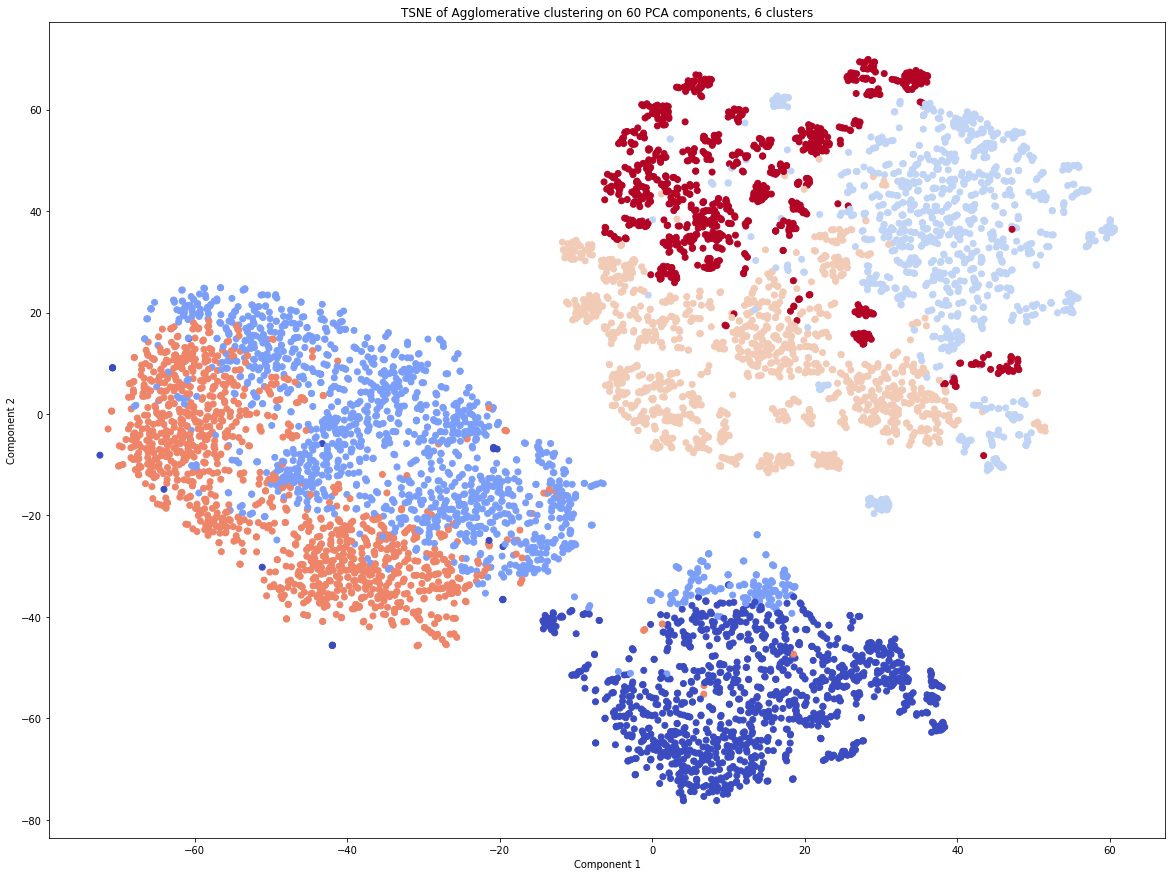

In [12]:
agglomerative_pipeline = get_model("agglomerative", X_train)
agglomerative_labels = agglomerative_pipeline["clustering"].labels_
plot_components(best_tsne.embedding_, labels=agglomerative_labels, title=False)
plt.title("TSNE of Agglomerative clustering on 60 PCA components, 6 clusters")
plt.show()

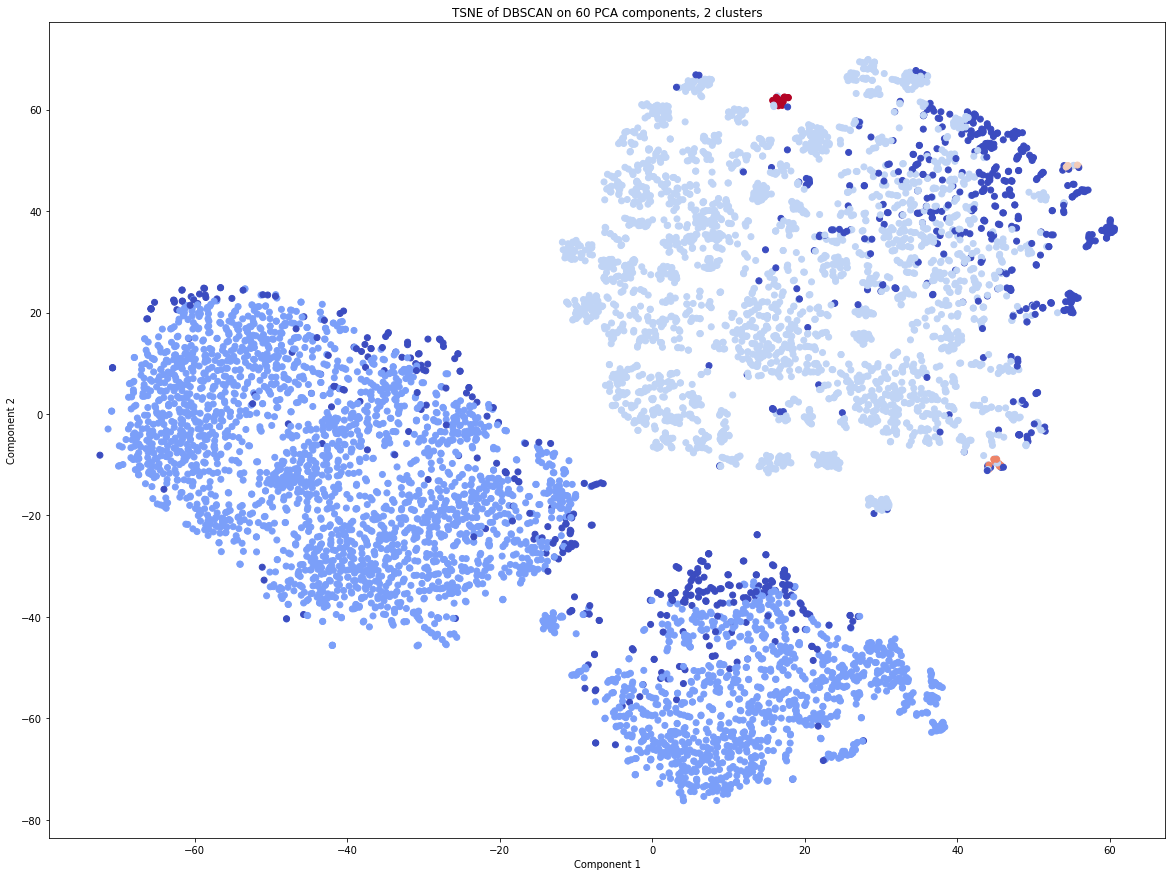

In [13]:
dbscan_pipeline = get_model("dbscan", X_train)
dbscan_labels = dbscan_pipeline["clustering"].labels_
plot_components(best_tsne.embedding_, labels=dbscan_labels, title=False)
plt.title("TSNE of DBSCAN on 60 PCA components, 2 clusters")
plt.show()
# rozdziela aktywności statyczne od dynamicznych

### GMM

In [23]:
def count_clustering_scores(X, cluster_num, model_class, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model_class(n_components=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

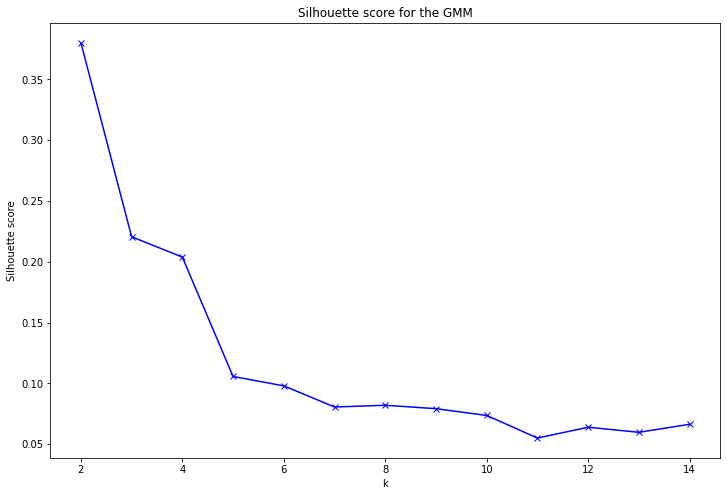

In [188]:
from sklearn.metrics import silhouette_score
from sklearn import mixture

cluster_num_seq = range(2, 15) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
pca = PCA(n_components = 60, random_state = 42)
X_train_pca = pca.fit_transform(X_train)
silhouette_vec = count_clustering_scores(X_train_pca, cluster_num_seq, mixture.GaussianMixture, silhouette_score)
f = plt.figure(figsize=(12, 8))
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.title('Silhouette score for the GMM')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

In [190]:
gmm = mixture.GaussianMixture(n_components=2)
gmm.fit(X_train_pca)

GaussianMixture(n_components=2)

Text(0.5, 1.0, 'GMM for 2 components')

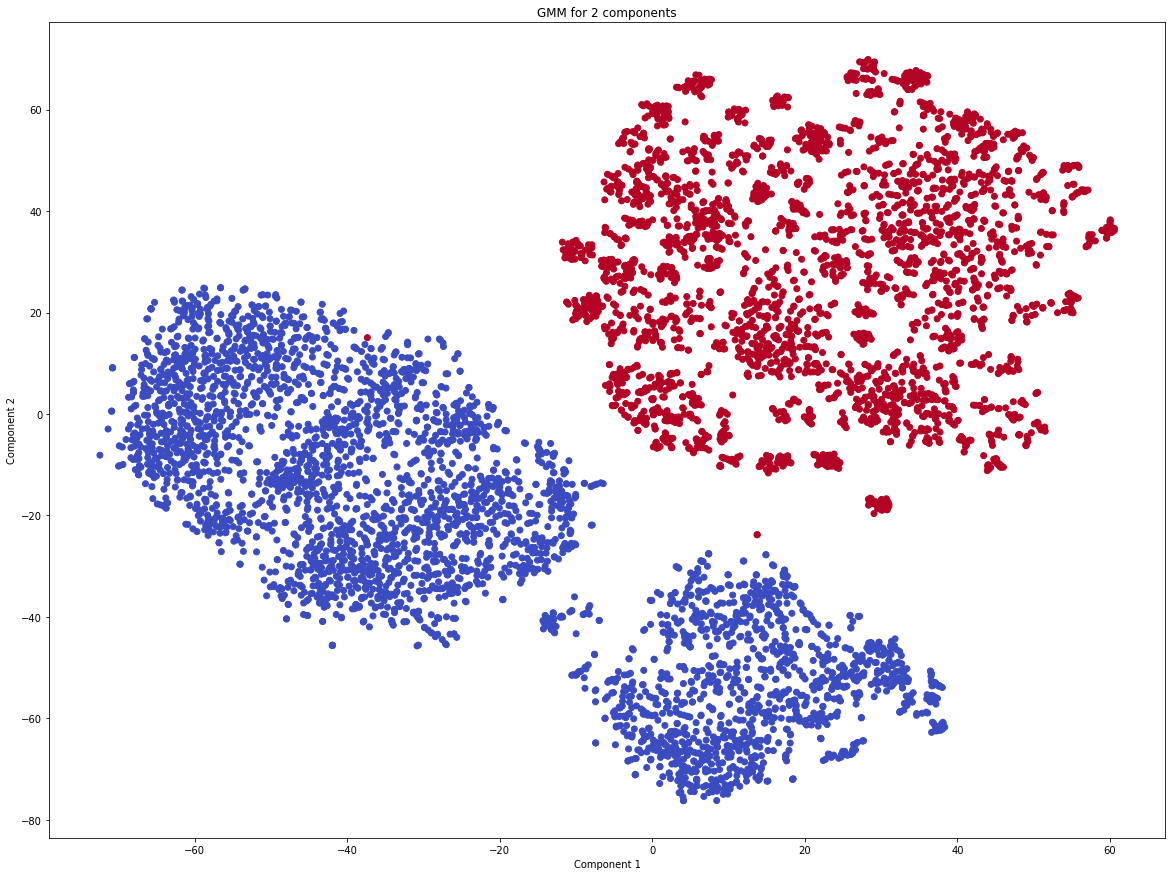

In [191]:
gmm_labels = gmm.predict(X_train_pca)
plot_components(best_tsne.embedding_,title=False, labels=gmm.predict(X_train_pca))
plt.title('GMM for 2 components')

In [192]:
# Biorąc pod uwagę dendogram z poprzedniego KM weźmy 6 komponentów
gmm = mixture.GaussianMixture(n_components=6)
gmm.fit(X_train_pca)


GaussianMixture(n_components=6)

Text(0.5, 1.0, 'GMM for 6 components')

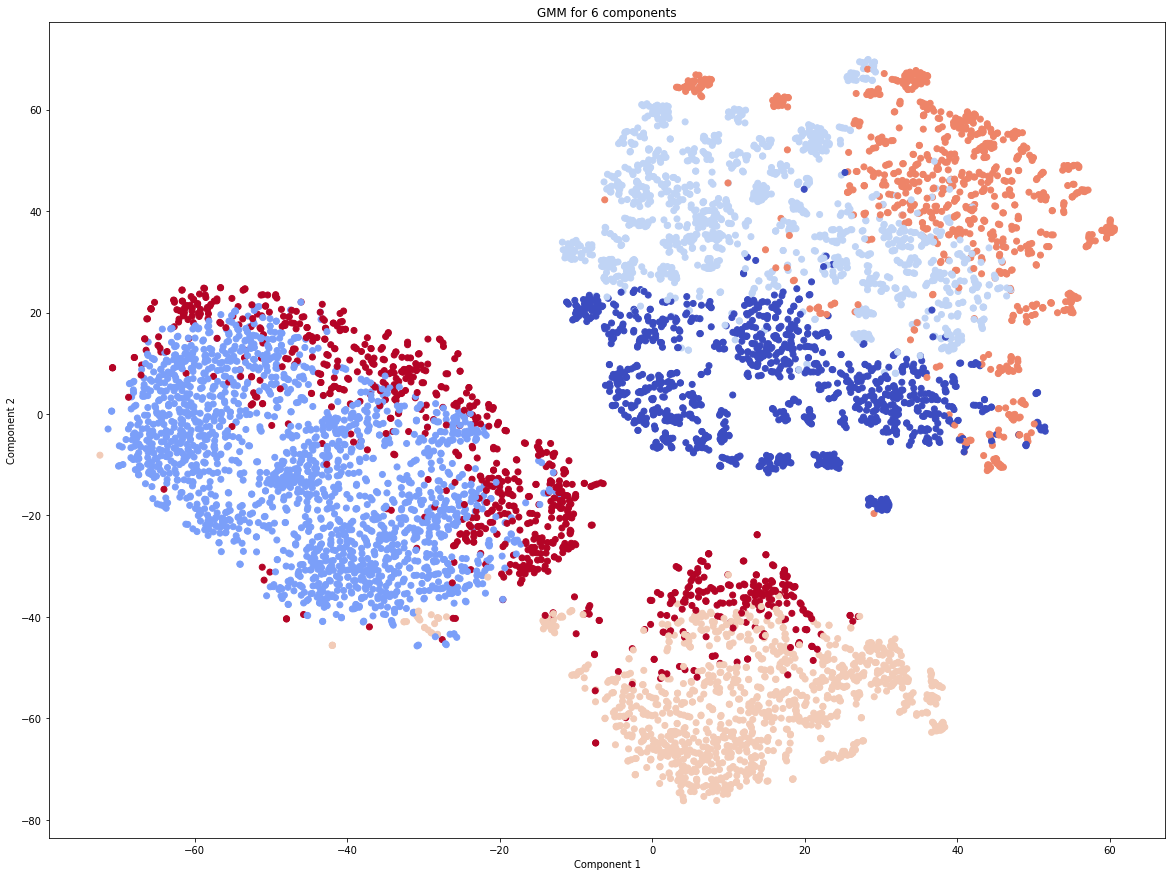

In [193]:
gmm_labels = gmm.predict(X_train_pca)
plot_components(best_tsne.embedding_, labels=gmm.predict(X_train_pca), title=False)
plt.title('GMM for 6 components')

## Porównanie z rzeczywistymi etykietami
Skoro metoda aglomeracyjna wypadła najlepiej, sprawdzimy jak predykcje na jej podstawie mają się do rzeczywistych etykiet.

Przypomnijmy sobie numerację aktywności:
1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING


In [14]:
label_matrix =  pd.crosstab(agglomerative_labels, y_train)
label_matrix
# klaster będziemy utożsamiać z tą etykietą, której w nim było najwięcej

Activity,1,2,3,4,5,6
row_0,,,,,,
0,0,0,0,13,5,1205
1,0,0,0,548,804,136
2,101,182,803,0,0,0
3,243,878,175,0,0,0
4,0,0,0,653,550,6
5,839,60,8,0,0,0


In [15]:
label_matrix = label_matrix.to_numpy()
cluster_labels = {}
print("cluster  --   label")
for i in range(label_matrix.shape[0]):
    cluster_labels[i] = np.argmax(label_matrix[i, :]) + 1
    print("   " + str(i) + "     --     " + str(cluster_labels[i]))

cluster  --   label
   0     --     6
   1     --     5
   2     --     3
   3     --     2
   4     --     4
   5     --     1


In [16]:
y_train_hat = np.zeros(y_train.shape[0])
for i in range(y_train.shape[0]):
    y_train_hat[i] = cluster_labels[agglomerative_labels[i]]

In [17]:
pd.crosstab(y_train_hat, y_train)
# to już było, ale jest teraz trochę bardziej czytelne
# na zbiorze treningowym klasteryzajca wyszła całkiem niezłą
# problematyczne do rozróżnienia są tylko 4(siedzenie) i 5(stanie)

Activity,1,2,3,4,5,6
row_0,,,,,,
1.0,839,60,8,0,0,0
2.0,243,878,175,0,0,0
3.0,101,182,803,0,0,0
4.0,0,0,0,653,550,6
5.0,0,0,0,548,804,136
6.0,0,0,0,13,5,1205


In [18]:
pca = agglomerative_pipeline["pca"]
X_test_pca = pca.transform(X_test)
X_train_pca = pca.transform(X_train)

k = int(np.sqrt(len(y_train)))
knc = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
knc.fit(X_train_pca, y_train_hat)
y_test_hat = knc.predict(X_test_pca)

In [19]:
pd.crosstab(y_test_hat, y_test)
# w miarę dobre predykcje

Activity,1,2,3,4,5,6
row_0,,,,,,
1.0,387,8,14,0,0,0
2.0,122,363,84,4,1,0
3.0,30,53,322,0,0,0
4.0,0,0,0,341,263,7
5.0,0,0,0,215,283,50
6.0,0,0,0,3,0,540


### GMM

In [211]:
label_matrix =  pd.crosstab(gmm_labels, y_train)
label_matrix
# klaster będziemy utożsamiać z tą etykietą, której w nim było najwięcej

Activity,1,2,3,4,5,6
row_0,,,,,,
0,140,952,64,0,0,0
1,0,0,0,853,1024,0
2,846,60,361,0,0,0
3,0,0,0,29,0,1109
4,197,108,561,0,0,0
5,0,0,0,332,335,238


In [212]:
label_matrix = label_matrix.to_numpy()
cluster_labels = {}
print("cluster  --   label")
for i in range(label_matrix.shape[0]):
    cluster_labels[i] = np.argmax(label_matrix[i, :]) + 1
    if i==5:
        cluster_labels[5] = 4
    print("   " + str(i) + "     --     " + str(cluster_labels[i]))


cluster  --   label
   0     --     2
   1     --     5
   2     --     1
   3     --     6
   4     --     3
   5     --     4


In [213]:
y_train_hat = np.zeros(y_train.shape[0])
for i in range(y_train.shape[0]):
    y_train_hat[i] = cluster_labels[gmm_labels[i]]

In [214]:
pd.crosstab(y_train_hat, y_train)

Activity,1,2,3,4,5,6
row_0,,,,,,
1.0,846,60,361,0,0,0
2.0,140,952,64,0,0,0
3.0,197,108,561,0,0,0
4.0,0,0,0,332,335,238
5.0,0,0,0,853,1024,0
6.0,0,0,0,29,0,1109


Wyniki przypominaja te co ostatnio. Jest problem z rozróżnieniem 4 i 5. Jednak ogólnie wyniki wydają się być  gorsze niz ostatnio. 